In [1]:
# File System
import os, sys, pickle as pkl
from os import path as pth
import itertools as it
from glob import glob

# Plotting
from matplotlib import pyplot as plt
from matplotlib import ticker as mticker
from corner import corner

# Math
import numpy as np
from numpy import linalg as la
import pandas as pd
pd.options.mode.chained_assignment = None

from scipy.stats import norm, uniform, multivariate_normal
from scipy.spatial.distance import cdist
import scipy.optimize as opt
from functools import reduce, partial
from itertools import product, combinations, combinations_with_replacement

#Data Structs
from collections import defaultdict

# Display
from IPython.display import clear_output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import logging as lg
lg.basicConfig(level=lg.INFO)

sys.path.append(pth.join(".."))
from Model import TwoSignal, Signal
from mcmc import MHMCMC

data_path = "data"

In [2]:
def format_params(bp, rp):
    rp0 = rp[0]
    return (bp.T/rp.T[0]).T, (rp.T/rp.T[0]).T

def prep_x_data(*args):
    return np.concatenate([*args],axis=1)

def fit_params(X, labels):
    return la.solve((X.T @ X), X.T @ labels)

def fit_params_ridge(X, Λ, labels):
    return la.solve((X.T @ X + Λ), X.T @ labels)

def rms(labels, β, X):
    return np.sqrt(np.mean(np.power(β@X.T - labels, 2)))

### Load Data

In [3]:
data = dict()

with open(glob(pth.join(data_path, "*train*"))[0],'rb') as tr\
    ,open(glob(pth.join(data_path, "*valid*"))[0],'rb') as vd:
        data['train'] = pkl.load(tr)
        data['valid'] = pkl.load(vd)

### Problem 1

In [4]:
t = data['train']

bp = t['bp_coef']
rp = t['rp_coef']
labels = t['labels'][:,0]

In [5]:
X = prep_x_data(*format_params(bp, rp))
β = fit_params(X, labels)

rms(labels, β, X)

108.032154255841

##### Check Validation

In [6]:
v = data['valid']

bp_valid = v['bp_coef']
rp_valid = v['rp_coef']
v_labels = v['labels'][:,0]

In [7]:
X_valid = prep_x_data(*format_params(bp_valid, rp_valid))

rms(v_labels, β, X_valid)

128.9816696764992

From root-mean square comparision of parameters, the found parameters are able to fit to the validation set well

### Problem 2

In [8]:
t = data['train']

bp = t['bp_coef']
rp = t['rp_coef']
labels = t['labels'][:,0]

_, rp2 = format_params(bp, rp)

v = data['valid']

bp_valid = v['bp_coef']
rp_valid = v['rp_coef']
v_labels = v['labels'][:,0]

_, v_rp2 = format_params(bp_valid, rp_valid)


In [9]:
sq_non_rpt_rang = [*combinations_with_replacement(np.arange(1,rp2.shape[1]),2)]
cu_non_rpt_rang = [*combinations_with_replacement(np.arange(1,rp2.shape[1]),3)]

#Train Terms
sq_terms = [rp2[:,x] * rp2[:,y] for x,y in sq_non_rpt_rang]
cu_terms = [rp2[:,x] * rp2[:,y] * rp2[:,z] for x,y,z in cu_non_rpt_rang]

#Valid Terms
v_sq_terms = [v_rp2[:,x] * v_rp2[:,y] for x,y in sq_non_rpt_rang]
v_cu_terms = [v_rp2[:,x] * v_rp2[:,y] * v_rp2[:,z] for x,y,z in cu_non_rpt_rang]

#### Linear Fit

##### Train

In [10]:
XL = prep_x_data(rp2)
βL = fit_params(XL, labels)

rms(labels, βL, XL)

171.0454462433648

##### Validate

In [11]:
XL_valid = prep_x_data(v_rp2)


rms(v_labels, βL, XL_valid)

198.98598170446655

##### Square Fit

##### Train

In [12]:
XS = prep_x_data(rp2, np.stack(sq_terms, axis=1))
βS = fit_params(XS, labels)

rms(labels, βS, XS)

69.4680240088949

##### Validate

In [13]:
XS_valid = prep_x_data(v_rp2, np.stack(v_sq_terms, axis=1))

rms(v_labels, βS, XS_valid)

2145.496146823512

##### Ridge Test (For Fun)

In [14]:
λ = 1e-5
ΛS = λ*np.eye(XS.shape[1])
βS_ridge = fit_params_ridge(XS, ΛS, labels)

rms(labels, βS_ridge, XS)
rms(v_labels, βS_ridge, XS_valid)

133.79111019459395

133.97175531089923

##### Cube Fit

##### Train

In [15]:
XC = prep_x_data(rp2, np.stack(sq_terms, axis=1), np.stack(cu_terms, axis=1))
βC = fit_params(XC, labels)

rms(labels, βC, XC)

3.951324984160421e-06

##### Validate

In [16]:
XC_valid = prep_x_data(v_rp2, np.stack(v_sq_terms, axis=1), np.stack(v_cu_terms, axis=1))

rms(v_labels, βC, XC_valid)

2069819.3577963437

##### Ridge Test (For Fun)

In [18]:
λ = 1e-6
ΛC = λ*np.eye(XC.shape[1])
βC_ridge = fit_params_ridge(XC, ΛC, labels)

rms(labels, βC_ridge, XC)
rms(v_labels, βC_ridge, XC_valid)

120.36578744103184

142.01882572070278

As the parameters grow, the overfitting grows too. Some improvement can be made using ridge regression

### Problem 3

In [2]:
with open(glob(pth.join(data_path, "*dataset11*"))[0], 'rb') as f:
    data3 = pkl.load(f)


In [74]:
def GP(X, Y, labels, λ=1, σ=1, τ=1):
    K11 = matern(X, X, σ, τ)
    K12 = matern(X, Y, σ, τ)
    K22 = matern(Y, Y, σ, τ)
    
    inv = la.solve((K11 + λ * np.eye(K11.shape[0])), K12).T
    return inv @ labels, np.sqrt(np.diag((K22 - inv @ K12)))

def matern(X, Y, σ=1, τ=1):
    dist = np.sqrt(3)/τ * cdist(X,Y, metric='minkowski',p=1)
    return np.power(σ,2) * (1 + dist) * np.exp(-dist)

In [86]:
X_p = np.expand_dims(np.linspace(-50, 1_234, num=10*2**10), 1)
time = np.expand_dims(data3.time, 1)
Y = np.expand_dims(data3.data, 1)

ys = [GP(time, X_p, Y, λ = 1e-1, τ=t) for t in (1, 1e1, 1e2)]

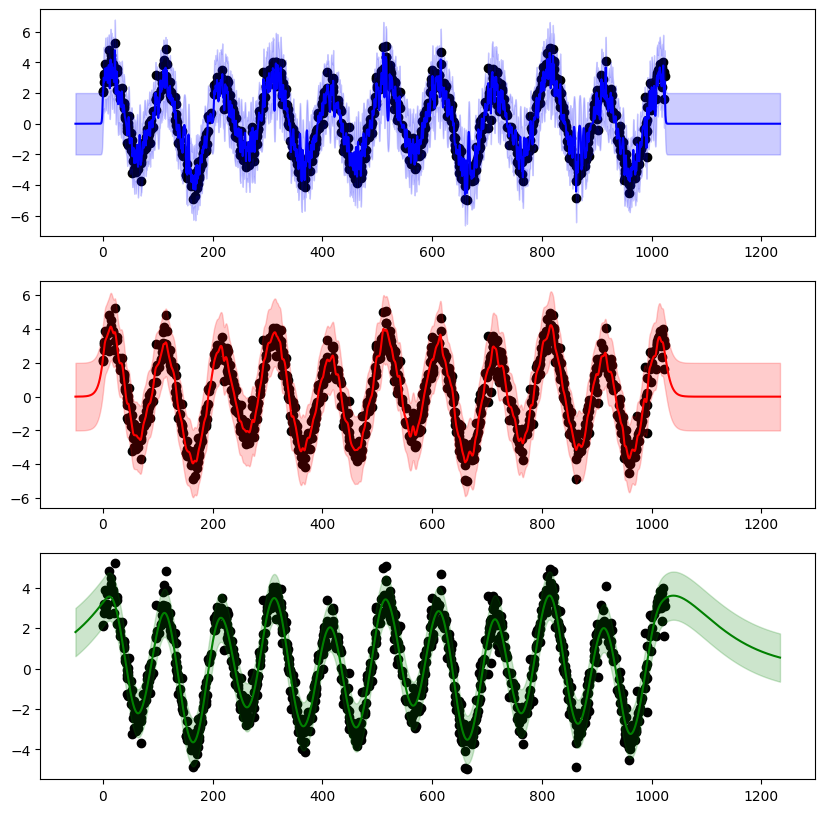

In [87]:
fig, axs = plt.subplots(3,1, figsize=(10,10))


colors = ('blue', 'red', 'green')

for (y, σ), c, l, ax in zip(ys, colors, (1e-2, 1, 1e2), axs):
    _ = ax.scatter(data3.time, data3.data, color="k")
    _ = ax.plot(X_p[:,0], y, label=l, color=c)
    _ = ax.fill_between(X_p[:,0], (y + 2*σ)[:,0], (y - 2*σ)[:,0], alpha=0.2, label=l, color=c)